# **a) Problem Statement**

Indonesia telah mencatat  total 6.078.725 kasus positif Covid-19 sejak pandemi hingga tanggal 25 Juni 2022 yang memiliki arti bahwa, Indonesia telah menempati peringkat pertama di Asia Tenggara dalam kasus positif Covid-19 tertinggi dengan kematian mencapai 156.714 orang. Sementara itu, diumumkan sebanyak 5.908.043 orang telah sembuh atau penyintas Covid-19.

Mobilitas masyarakat sangat erat kaitanya dan diduga dapat berpengaruh terhadap jumlah kasus Covid-19. Mobilitas masyarakat dipetakan menjadi berbagai macam kategori, diantara lainnya seperti tempat retail dan rekreasi, toko bahan makanan dan apotek, taman, pusat transportasi umum, tempat kerja, serta perumahan. Mobilitas penduduk berpengaruh terhadap interaksi sosial masyarakat, semakin tinggi pergerakan penduduk maka semakin tinggi interaksi yang dapat menimbulkan penyebaran virus. 

Karena itu, penting untuk mengetahui kategori apa saja dan seberapa besar faktor tersebut mempengaruhi kasus Covid-19 di Indonesia, agar dapat diberi solusi berbasis data berupa keputusan yang paling baik dan relevan untuk pemulihan Covid-19. Dari hasil analisis kami, diharapkan dapat membantu pemerintah dalam menerapkan kebijakan yang tepat serta membantu masyarakat untuk melakukan pencegahan pribadi dalam menghadapi persebaran Covid-19 ini.

###Data dan Metode

Dalam *notebook* ini kami menggunakan dua dataset, yaitu data harian Covid-19 Indonesia yang disediakan oleh pemerintah provinsi DKI Jakarta serta data mobilitas yang diperoleh dari  *Covid-19 Community
Mobility Reports*, disusun oleh Google. Dari kedua dataset tersebut, kami melakukan analisis pengaruh faktor-faktor mobilitas terhadap peningkatan kasus positif harian Covid-19 pada tahun 2022, lebih tepatnya mulai dari tanggal 1 Januari 2022 hingga 20 Juni 2022.

Pada penganalisaannya, kami melakukan data *cleaning*, *preprocessing*, eksplorasi dan visualisasi data, hingga pada tahap *modelling*. Kami menggunakan algoritma *machine learning* yaitu *regression*. Namun, data yang kami miliki tidak memenuhi beberapa asumsi regresi linear, yaitu terdapat multikolinearitas dan autokorelasi sehingga tidak bisa menggunakan model regresi linear biasa. Selain itu, ditemukan bahwa variansi dari variabel responnya lebih besar daripada nilai rataannya. Maka sebagai alternatif, kami menggunakan **Model Regresi Binomial Negatif** (*Negative Binomial Regression*). 

*Negative Binomial Regression* (NBR) merupakan model yang berasal dari distribusi poisson-gamma yang biasa digunakan untuk memprediksi data *time series* yang datanya *count-based* serta variabel responnya berupa bilangan bulat non-negatif. Setelah ditemukan model yang tepat, akan ada komparasi antara nilai aktual dan prediksi dari kasus Covid hariannya. Dengan demikian, dapat diperoleh kesimpulan dari data Covid-19 dan mobilitas yang kami analisis.

# **b) Data Cleaning and Preprocessing**

In [ ]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.formula.api import glm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

In [ ]:
#Import Data Mobility https://www.google.com/covid19/mobility/ 
indo20 = pd.read_csv('https://raw.githubusercontent.com/raistra/compfestdata/main/Copy%20of%202020_ID_Region_Mobility_Report.csv')
indo21 = pd.read_csv('https://raw.githubusercontent.com/raistra/compfestdata/main/Copy%20of%202021_ID_Region_Mobility_Report.csv')
indo22 = pd.read_csv('https://raw.githubusercontent.com/raistra/compfestdata/main/Copy%20of%202022_ID_Region_Mobility_Report.csv')

#Import Data Covid 19 https://tiny.cc/Datacovidjakarta
covid_indojak = pd.read_excel('https://github.com/raistra/compfestdata/blob/main/Copy%20of%20Daily%20Update%20Data%20Agregat%20Covid-19%20Indonesia%20Jakarta.xlsx?raw=true')

In [ ]:
#Menggabungkan Dataframe Indo20, Indo21, Indo22
mob = indo20.append(indo21)
mob = mob.append(indo22)

#Melihat Data Mobility Teratas
mob.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,ID,Indonesia,NaN,NaN,NaN,NaN,NaN,ChIJtwRkSdcHTCwRhfStG-dNe-M,2020-02-15,-2.0,-2.0,-8.0,1.0,5,1
1,ID,Indonesia,NaN,NaN,NaN,NaN,NaN,ChIJtwRkSdcHTCwRhfStG-dNe-M,2020-02-16,-3.0,-3.0,-7.0,-4.0,2,2
2,ID,Indonesia,NaN,NaN,NaN,NaN,NaN,ChIJtwRkSdcHTCwRhfStG-dNe-M,2020-02-17,-3.0,-4.0,-7.0,-1.0,3,1
3,ID,Indonesia,NaN,NaN,NaN,NaN,NaN,ChIJtwRkSdcHTCwRhfStG-dNe-M,2020-02-18,-3.0,-2.0,-4.0,1.0,2,1
4,ID,Indonesia,NaN,NaN,NaN,NaN,NaN,ChIJtwRkSdcHTCwRhfStG-dNe-M,2020-02-19,-3.0,-4.0,-3.0,0.0,1,1


In [ ]:
#Melihat Ukuran Data Mobilitas
mob.shape

(29995, 15)

In [ ]:
#Melihat Info Data Mobilitas
mob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29995 entries, 0 to 5984
Data columns (total 15 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   country_region_code                                 29995 non-null  object 
 1   country_region                                      29995 non-null  object 
 2   sub_region_1                                        29138 non-null  object 
 3   sub_region_2                                        0 non-null      float64
 4   metro_area                                          0 non-null      float64
 5   iso_3166_2_code                                     29138 non-null  object 
 6   census_fips_code                                    0 non-null      float64
 7   place_id                                            29995 non-null  object 
 8   date                                                29995 non-null  object 
 

In [ ]:
#Rename kolom dari data mobilitas
mob = mob.rename({'retail_and_recreation_percent_change_from_baseline': 'retail_and_recreation', 'grocery_and_pharmacy_percent_change_from_baseline': "grocery_and_pharmacy",
                    'parks_percent_change_from_baseline': 'parks', 'transit_stations_percent_change_from_baseline': 'transit_stations', 
                    'workplaces_percent_change_from_baseline': 'workplaces','residential_percent_change_from_baseline': 'residential'}, axis=1)
mob.head(3)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,ID,Indonesia,NaN,NaN,NaN,NaN,NaN,ChIJtwRkSdcHTCwRhfStG-dNe-M,2020-02-15,-2.0,-2.0,-8.0,1.0,5,1
1,ID,Indonesia,NaN,NaN,NaN,NaN,NaN,ChIJtwRkSdcHTCwRhfStG-dNe-M,2020-02-16,-3.0,-3.0,-7.0,-4.0,2,2
2,ID,Indonesia,NaN,NaN,NaN,NaN,NaN,ChIJtwRkSdcHTCwRhfStG-dNe-M,2020-02-17,-3.0,-4.0,-7.0,-1.0,3,1


In [ ]:
#Melihat Data Covid-19 Teratas
covid_indojak.head()

,Tanggal,Positif (Indonesia),Dirawat (Indonesia),Sembuh (Indonesia),Meninggal (Indonesia),Meninggal (Jakarta),Sembuh (Jakarta),Self-Isolation (Jakarta),Dirawat (Jakarta),Positif (Jakarta),...,Positif Harian (Indonesia),Dirawat Harian (Indonesia),Sembuh Harian (Indonesia),Meninggal Harian (Indonesia),Meninggal Harian (Jakarta),Sembuh Harian (Jakarta),Self-Isolation Harian (Jakarta),Dirawat Harian (Jakarta),Positif Harian (Jakarta),Positif Aktif Harian (Jakarta)
0,2020-01-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2020-03-02,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,2,0,0,0,0,0,0,0,0
3,2020-03-03,2.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,3.0,...,0,0,0,0,1,0,0,2,3,2
4,2020-03-04,2.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Melihat Ukuran Data Covid-19
covid_indojak.shape

(847, 21)

In [ ]:
#Melihat Info Data Covid-19
covid_indojak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Tanggal                          847 non-null    datetime64[ns]
 1   Positif (Indonesia)              846 non-null    float64       
 2   Dirawat (Indonesia)              846 non-null    float64       
 3   Sembuh (Indonesia)               846 non-null    float64       
 4   Meninggal (Indonesia)            846 non-null    float64       
 5   Meninggal (Jakarta)              846 non-null    float64       
 6   Sembuh (Jakarta)                 846 non-null    float64       
 7   Self-Isolation (Jakarta)         846 non-null    float64       
 8   Dirawat (Jakarta)                846 non-null    float64       
 9   Positif (Jakarta)                846 non-null    float64       
 10  Positif Aktif (Jakarta)          846 non-null    float64      

In [ ]:
#Menghapus kolom Covid-19 Jakarta, karena yang akan digunakan adalah data Covid-19 untuk Indonesia
covid_indo = covid_indojak.drop(covid_indojak.columns[[5, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19, 20]], axis=1)

#Rename kolom data Covid-19
covid_indo.rename(columns = {'Positif (Indonesia)':'positif','Dirawat (Indonesia)':'dirawat','Sembuh (Indonesia)':'sembuh','Meninggal (Indonesia)':'meninggal',
                        'Positif Harian (Indonesia)':'positif_harian','Dirawat Harian (Indonesia)':'dirawat_harian','Sembuh Harian (Indonesia)':'sembuh_harian',
                        'Meninggal Harian (Indonesia)':'meninggal_harian'}, inplace=True)
covid_indo.head(3)

,Tanggal,positif,dirawat,sembuh,meninggal,positif_harian,dirawat_harian,sembuh_harian,meninggal_harian
0,2020-01-29,0.0,0.0,0.0,0.0,0,0,0,0
1,2020-03-01,0.0,0.0,0.0,0.0,0,0,0,0
2,2020-03-02,2.0,2.0,0.0,0.0,2,2,0,0


### Missing Values

In [ ]:
#Memeriksa Missing-Value pada Data Mobilitas

print('Jumlah Missing-Value pada Setiap Kolom:')
print(mob.isnull().sum())

print('\nJumlah Missing-Value Total:')
print(mob.isnull().sum().sum())

Jumlah Missing-Value pada Setiap Kolom:
country_region_code          0
country_region               0
sub_region_1               857
sub_region_2             29995
metro_area               29995
iso_3166_2_code            857
census_fips_code         29995
place_id                     0
date                         0
retail_and_recreation       50
grocery_and_pharmacy        99
parks                      118
transit_stations           837
workplaces                   0
residential                  0
dtype: int64

Jumlah Missing-Value Total:
92803


In [ ]:
#Menghapus kolom dari data mobilitas
mob = mob.drop(columns=['country_region_code','sub_region_2','metro_area','iso_3166_2_code','census_fips_code','place_id'])

#Menghilangkan nilai NaN
mob = mob.dropna()
mob.head()

,country_region,sub_region_1,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
321,Indonesia,Aceh,2020-02-15,-1.0,-2.0,-7.0,-3.0,3,2
322,Indonesia,Aceh,2020-02-16,4.0,3.0,5.0,4.0,3,1
323,Indonesia,Aceh,2020-02-17,4.0,1.0,5.0,10.0,8,0
324,Indonesia,Aceh,2020-02-18,0.0,-1.0,0.0,0.0,5,1
325,Indonesia,Aceh,2020-02-19,-2.0,-3.0,2.0,4.0,6,1


In [ ]:
#Cek NaN
mob.isnull().values.any()

False

In [ ]:
#Memeriksa Missing-Value pada Data Covid-19

print('Jumlah Missing-Value pada Setiap Kolom:')
print(covid_indojak.isnull().sum())

print('\nJumlah Missing-Value Total:')
print(covid_indojak.isnull().sum().sum())

Jumlah Missing-Value pada Setiap Kolom:
Tanggal                            0
Positif (Indonesia)                1
Dirawat (Indonesia)                1
Sembuh (Indonesia)                 1
Meninggal (Indonesia)              1
Meninggal (Jakarta)                1
Sembuh (Jakarta)                   1
Self-Isolation (Jakarta)           1
Dirawat (Jakarta)                  1
Positif (Jakarta)                  1
Positif Aktif (Jakarta)            1
Positif Harian (Indonesia)         0
Dirawat Harian (Indonesia)         0
Sembuh Harian (Indonesia)          0
Meninggal Harian (Indonesia)       0
Meninggal Harian (Jakarta)         0
Sembuh Harian (Jakarta)            0
Self-Isolation Harian (Jakarta)    0
Dirawat Harian (Jakarta)           0
Positif Harian (Jakarta)           0
Positif Aktif Harian (Jakarta)     0
dtype: int64

Jumlah Missing-Value Total:
10


In [ ]:
#Menghapus Nilai NaN
covid = covid_indo.dropna()
covid.head()

,Tanggal,positif,dirawat,sembuh,meninggal,positif_harian,dirawat_harian,sembuh_harian,meninggal_harian
0,2020-01-29,0.0,0.0,0.0,0.0,0,0,0,0
1,2020-03-01,0.0,0.0,0.0,0.0,0,0,0,0
2,2020-03-02,2.0,2.0,0.0,0.0,2,2,0,0
3,2020-03-03,2.0,2.0,0.0,0.0,0,0,0,0
4,2020-03-04,2.0,2.0,0.0,0.0,0,0,0,0


In [ ]:
#Cek NaN
covid.isnull().values.any()

False

###Duplikasi Data

In [ ]:
#Memeriksa Duplikasi pada Data Mobilitas
mob.duplicated().sum()

0

In [ ]:
#Memeriksa Duplikasi pada Data Covid-19
covid.duplicated().sum()

0

###Outlier

In [ ]:
#Outlier pada Data Covid-19
Q1 = covid.quantile(0.25)
Q3 = covid.quantile(0.75)
IQR = Q3-Q1

def detect_outliers(df, x):
    Q1 = df[x].describe()['25%']
    Q3 = df[x].describe()['75%']
    IQR = Q3-Q1
    return df[(df[x] < Q1-1.5*IQR) | (df[x] > Q3+1.5*IQR)]
  
detect_outliers(covid, 'positif_harian')

,Tanggal,positif,dirawat,sembuh,meninggal,positif_harian,dirawat_harian,sembuh_harian,meninggal_harian
481,2021-06-24,2053995.0,171542.0,1826504.0,55949.0,20574,11018,9201,355
482,2021-06-25,2072867.0,181435.0,1835061.0,56371.0,18872,9893,8557,422
483,2021-06-26,2093962.0,194776.0,1842457.0,56729.0,21095,13341,7396,358
484,2021-06-27,2115304.0,207685.0,1850481.0,57138.0,21342,12909,8024,409
485,2021-06-28,2135998.0,218476.0,1859961.0,57561.0,20694,10791,9480,423
...,...,...,...,...,...,...,...,...,...
737,2022-03-07,5770105.0,448273.0,5171402.0,150430.0,21380,-27678,48800,258
738,2022-03-08,5800253.0,422892.0,5226530.0,150831.0,30148,-25381,55128,401
739,2022-03-09,5826589.0,417219.0,5258235.0,151135.0,26336,-5673,31705,304
740,2022-03-10,5847900.0,399852.0,5296634.0,151413.0,21311,-17367,38399,278


In [ ]:
#Outlier Data Mobilitas
Q1 = mob.quantile(0.25)
Q3 = mob.quantile(0.75)
IQR = Q3-Q1

def detect_outliers(df, x):
    Q1 = df[x].describe()['25%']
    Q3 = df[x].describe()['75%']
    IQR = Q3-Q1
    return df[(df[x] < Q1-1.5*IQR) | (df[x] > Q3+1.5*IQR)]
  
detect_outliers(mob, 'parks')

,country_region,sub_region_1,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
681,Indonesia,Bali,2020-03-25,-89.0,-92.0,-78.0,-95.0,-89,37
698,Indonesia,Bali,2020-04-11,-46.0,-35.0,-65.0,-73.0,-40,18
699,Indonesia,Bali,2020-04-12,-50.0,-38.0,-67.0,-75.0,-34,18
705,Indonesia,Bali,2020-04-18,-49.0,-38.0,-67.0,-74.0,-38,18
706,Indonesia,Bali,2020-04-19,-52.0,-41.0,-69.0,-75.0,-34,18
...,...,...,...,...,...,...,...,...,...
5963,Indonesia,West Sumatra,2022-05-30,40.0,71.0,66.0,20.0,23,16
5964,Indonesia,West Sumatra,2022-05-31,39.0,72.0,65.0,21.0,21,14
5965,Indonesia,West Sumatra,2022-06-01,50.0,83.0,112.0,16.0,-32,23
5972,Indonesia,West Sumatra,2022-06-08,41.0,78.0,64.0,6.0,24,17


###Data Preparation

In [ ]:
#Membuat DataFrame baru untuk jumlah kasus positif harian dan rata-rata mobilitas tiap bulan, dari Maret 2020-Juni 2022

#DataFrame jumlah kasus positif tiap bulan
covid['Bulan'] = covid['Tanggal'].apply(lambda x: x.strftime('%Y-%m'))
monthly = covid.groupby('Bulan')['positif_harian'].sum().reset_index()

#DataFrame rata-rata mobilitas tiap bulan
mob['Bulan'] = mob['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%Y-%m'))
mob_monthly = mob.groupby(['Bulan']).mean().reset_index()

#Menggabungkan dua DataFrame sebelumnya (monthly dan mob_monthly)
df = monthly[['Bulan', 'positif_harian']].merge(mob_monthly, how = 'inner', on = 'Bulan')
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Bulan,positif_harian,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,2020-03,1528,-12.773730,-4.518696,-13.485139,-16.000959,-8.015340,5.711409
1,2020-04,8590,-38.201183,-21.251479,-33.337278,-53.664694,-28.875740,14.438856
2,2020-05,16355,-34.014272,-13.379638,-31.128449,-58.291151,-28.717412,14.738344
3,2020-06,29912,-22.662722,-8.637081,-20.313609,-47.345168,-17.353057,11.091716
4,2020-07,51991,-15.742584,-3.122488,-14.407656,-37.751196,-16.662201,9.775120


In [ ]:
#Membuat DataFrame baru untuk jumlah kasus positif harian dan rata-rata mobilitas tiap harinya, tahun 2022

#DataFrame rata-rata mobilitas setiap hari
mob2 = mob.groupby(['date']).mean().reset_index()
mob2.rename(columns = {'date':'Tanggal'}, inplace = True)

#Menggabungkan data Covid-19 dan data Mobilitas dengan irisan pada kolom Tanggal
covid.Tanggal = covid.Tanggal.astype('str')
df2 = covid[['Tanggal', 'positif_harian']].merge(mob2, how = 'inner', on = 'Tanggal')

#Data Kasus Positif Harian dan Mobilitas Tahun 2022
df3 = df2.copy()
df3['Tahun'] = df3['Tanggal'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%Y'))
df3 = df3[df3['Tahun']== '2022']
df3.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Tanggal,positif_harian,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,Tahun
671,2022-01-01,274,1.969697,24.727273,45.484848,-18.212121,-47.242424,2.636364,2022
672,2022-01-02,174,13.454545,41.272727,29.545455,-3.060606,-8.363636,0.212121,2022
673,2022-01-03,265,15.090909,43.090909,17.181818,-3.848485,-10.393939,-0.454545,2022
674,2022-01-04,299,13.090909,40.272727,11.848485,-2.393939,-8.696970,-0.454545,2022
675,2022-01-05,404,15.242424,42.818182,14.333333,-2.484848,-6.090909,-0.484848,2022


# **c) Exploratory Data Analysis**

In [ ]:
#Statistika deskriptif data harian tahun 2022
df3.describe()

,positif_harian,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000
mean,10564.532164,14.330852,42.740386,42.965267,-1.748538,4.981925,10.474216
std,17057.827391,7.956153,11.192710,31.947142,12.550344,18.443110,5.667670
min,107.000000,-10.212121,24.727273,3.000000,-21.969697,-64.757576,-0.636364
25%,397.500000,9.075758,35.287879,12.848485,-9.696970,-0.969697,4.924242
50%,1242.000000,13.454545,41.242424,47.181818,-3.636364,8.454545,12.909091
75%,12005.000000,18.575758,46.500000,60.151515,2.969697,15.454545,14.439394
max,64718.000000,41.454545,101.060606,185.787879,39.030303,32.666667,23.666667


Dari hasil statistika deskriptif di atas, terlihat bahwa nilai rataan dari variabel responnya yaitu 10564.32164. Standar deviasi dari variabel responnya yaitu 17057,827391 sehingga variansinya adalah 290969000. Terlihat bahwa nilai variansi variabel responnya lebih besar daripada nilai rataannya. Hal ini menunjukkan bahwa data yang kita miliki mendukung untuk dilakukan analisis regresi binomial negatif.

Selain itu, dapat diketahui juga bahwa rata-rata jumlah kasus positif harian pada tahun 2022 adalah sekitar 10564,3 dengan jumlah maksimum hariannya 64718 dan jumlah minimum hariannya 107.

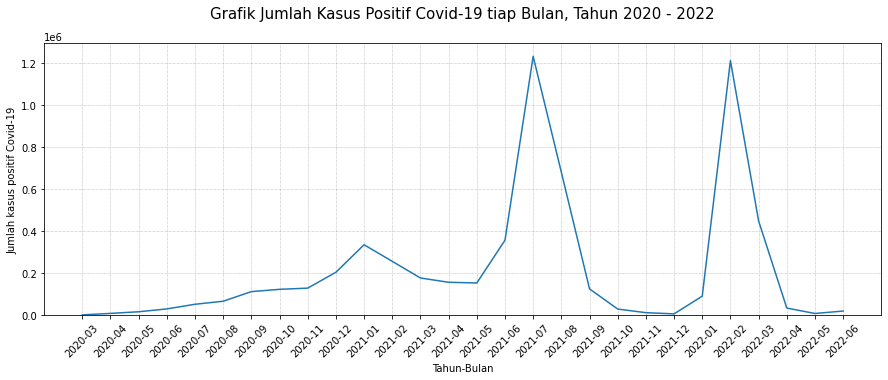

In [ ]:
#Line-Chart Jumlah Kasus Positif Tiap Bulan

plt.figure(figsize=(15,5))
plt.plot(df['Bulan'],df['positif_harian'])
plt.title('Grafik Jumlah Kasus Positif Covid-19 tiap Bulan, Tahun 2020 - 2022', pad = 25, fontsize = 15)
plt.xlabel('Tahun-Bulan')
plt.ylabel('Jumlah kasus positif Covid-19')
plt.xticks(rotation = 45)
plt.ylim(ymin=0)
plt.grid(color = 'grey', linewidth = 0.5, linestyle = ':')
plt.show()

Berdasarkan *line-chart* di atas, terlihat bahwa jumlah kasus positif Covid-19 mulai mengalami kenaikan yang cukup signifikan pada bulan Desember 2020 dan Januari 2021. Kemudian memasuki bulan Februari 2021, jumlah kasus mulai mengalami penurunan. Hal ini terjadi diduga karena diterapkannya kebijakan PPKM (Pemberlakuan Pembatasan Kegiatan Masyarakat) oleh pemerintah untuk pulau jawa-bali serta dimulainya program vaksinasi. Kemudian jumlah kasus positif kembali mengalami kenaikan di bulan Juni 2021 sampai puncaknya yaitu di bulan Juli 2021. Memasuki bulan Agustus 2021, kasus positif Covid-19 mengalami penurunan yang sangat signifikan.

Puncak kenaikan jumlah kasus positif Covid-19 kembali terjadi pada bulan Februari 2022 dan mengalami penurunan yang signifikan di bulan Maret 2022 dan April 2022.

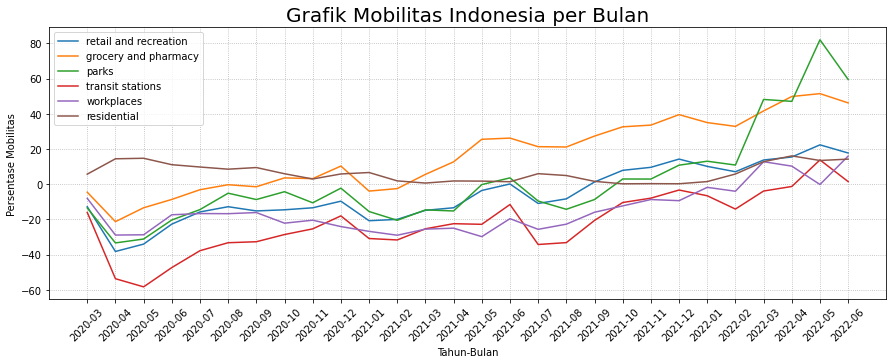

In [ ]:
#Line-Chart rata-rata mobilitas tiap bulan

plt.figure(figsize=(15,5))
plt.plot(df['Bulan'], df['retail_and_recreation'],label = 'retail and recreation')
plt.plot(df['Bulan'], df['grocery_and_pharmacy'], label = 'grocery and pharmacy')
plt.plot(df['Bulan'], df['parks'], label = 'parks')
plt.plot(df['Bulan'], df['transit_stations'], label = 'transit stations')
plt.plot(df['Bulan'], df['workplaces'], label = 'workplaces')
plt.plot(df['Bulan'], df['residential'], label = 'residential')

plt.title('Grafik Mobilitas Indonesia per Bulan', fontsize = 20)
plt.xlabel('Tahun-Bulan')
plt.ylabel('Persentase Mobilitas')
plt.xticks(rotation = 45)
plt.grid(linestyle = ':')
plt.legend()
plt.show()

Selanjutnya, akan dilakukan analisis pada grafik rata-rata pergerakan mobilitas masyarakat Indonesia yang dibandingkan dengan grafik jumlah kasus positif Covid-19 sebelumnya. Berdasarkan *line-chart* data mobilitas tiap bulan, dapat kita lihat bahwa mobilitas di area perumahan cenderung stabil, tidak ada kenaikan atau penurunan yang signifikan di setiap bulannya. Selain area perumahan, mobilitas di beberapa area mengalami penurunan yang cukup signifikan pada bulan April 2020, diduga karena mulai berkembangnya persebaran Covid-19 di indonesia yang membuat masyarakat waspada dan mulai mengurangi kegiatan di luar rumah, terutama di tempat yang biasanya sangat ramai yaitu pusat transportasi umum.

Pada bulan Desember 2020, terdapat peningkatan mobilitas masyarakat di sejumlah area selain perumahan, yang berarti meningkatnya aktivitas masyarakat di luar rumah. Hal ini diduga sebagai penyebab jumlah kasus positif Covid-19 mulai mengalami peningkatan. Dengan diberlakukannya PPKM untuk pulau jawa-bali pada bulan Januari 2021, rata-rata mobilitas di Indonesia mulai menurun, terlihat dari grafik yang menurun di bulan Januari 2021. 

Kemudian di bulan Juni 2021, mobilitas masyarakat kembali mengalami kenaikan, diikuti dengan kenaikan jumlah kasus positif Covid-19 di bulan tersebut, dan mengalami penurunan rata-rata mobilitas ketika terjadi puncak kenaikan kasus Covid-19 di bulan Juli 2021. Kejadian serupa juga terjadi pada bulan Februari 2022.


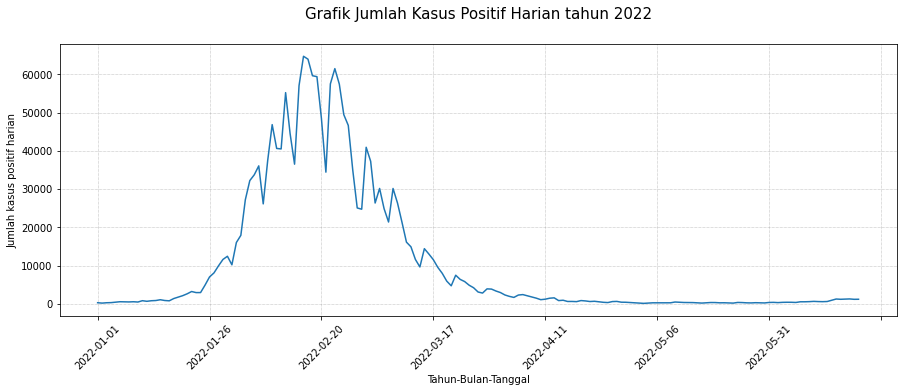

In [ ]:
#Line-Chart Jumlah Kasus Positif 2022

plt.figure(figsize=(15,5))
df4 = df3.set_index('Tanggal')
df4['positif_harian'].plot()
plt.title('Grafik Jumlah Kasus Positif Harian tahun 2022', pad = 25, fontsize = 15)
plt.xlabel('Tahun-Bulan-Tanggal')
plt.ylabel('Jumlah kasus positif harian')
plt.xticks(rotation = 45)
plt.grid(color = 'grey', linewidth = 0.5, linestyle = ':')
plt.show()

Dari grafik jumlah kasus positif Covid-19 untuk tahun 2022, terlihat bahwa terdapat naik turun pada grafik, dimana jumlah kasus positif Covid-19 mulai naik di pertengahan Januari 2022 sebanyak 274 kasus, kemudian cenderung mengalami kenaikan sampai puncaknya yaitu awal bulan Februari 2022 dengan jumlah kasus positif sebanyak 64.718. Setelah itu, jumlah kasus positif cenderung mengalami penurunan hingga mencapai 107 kasus pada pertengahan Mei.

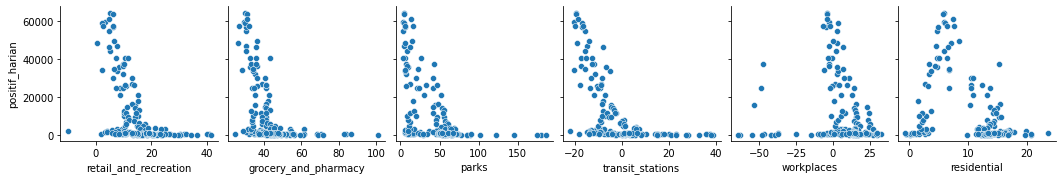

In [ ]:
#Scatter Plot masing-masing variabel
sns.pairplot(data=df3,
                     x_vars=['retail_and_recreation', 'grocery_and_pharmacy', 'parks','transit_stations','workplaces','residential'],
                     y_vars=['positif_harian'])

Pada gambar diatas, disajikan scatter plot untuk melihat suatu pola hubungan data positif harian Covid-19 dengan masing-masing variabel mobilitas masyarakat. Dapat dilihat pada masing-masing grafik bahwa tidak ada pola yang membentuk garis lurus, sehingga hubungan pada kedua variabel tersebut tidak berhubungan linier. Penyebaran data pada masing-masing grafik menyerupai pola yang sama, meningkat dan menurun secara drastis, kemudian data poin bergerak secara horizontal, tidak bertambah atau berkurang.

In [ ]:
#Korelasi antar-variabel pada data 2022
corr = df3.corr()
corr.style.background_gradient(cmap='coolwarm')

,positif_harian,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
positif_harian,1.000000,-0.486785,-0.449297,-0.476875,-0.546095,-0.155755,-0.327727
retail_and_recreation,-0.486785,1.000000,0.907614,0.766100,0.883875,-0.132385,0.379896
grocery_and_pharmacy,-0.449297,0.907614,1.000000,0.662649,0.809673,-0.037541,0.454532
parks,-0.476875,0.766100,0.662649,1.000000,0.727599,-0.257397,0.651443
transit_stations,-0.546095,0.883875,0.809673,0.727599,1.000000,-0.094105,0.342188
workplaces,-0.155755,-0.132385,-0.037541,-0.257397,-0.094105,1.000000,0.150591
residential,-0.327727,0.379896,0.454532,0.651443,0.342188,0.150591,1.000000


Terdapat korelasi yang cukup kuat antara jumlah kasus positif harian Covid-19 dengan rata-rata mobilitas di area retail dan rekreasi, pusat perbelanjaan dan apotek, taman, dan pusat transportasi umum. Artinya kenaikan kasus covid-19 bisa dipengaruhi oleh faktor mobilitas di area-area tersebut. Kemudian korelasi antara jumlah kasus positif harian Covid-19 dengan mobilitas di area tempat kerja dan perumahan relatif kecil, sehingga dapat dikatakan bahwa mobilitas di area tempat kerja dan perumahan tidak memberikan pengaruh yang signifikan terhadap kenaikan/penurunan jumlah kasus positif harian Covid-19. Namun, perlu diperhatikan bahwa korelasinya negatif semua. Hal ini menunjukkan bahwa hubungan antara variabel respon dan variabel bebasnya memiliki korelasi negatif, sehingga dapat dikatakan bahwa ketika jumlah kasus positif harian Covid-19 mengalami penurunan, mobilitas masyarakat Indonesia cenderung mengalami kenaikan.

Selain itu, terlihat bahwa kebanyakan antar-variabel responnya memiliki korelasi yang cukup tinggi, yaitu diatas 0.4 yang berarti bahwa terdapat multikolinearitas pada data sehingga terbukti bahwa kita tidak bisa menggunakan model regresi linear biasa.

# **d) Modelling**

In [ ]:
df3.head(3)

,Tanggal,positif_harian,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,Tahun
671,2022-01-01,274,1.969697,24.727273,45.484848,-18.212121,-47.242424,2.636364,2022
672,2022-01-02,174,13.454545,41.272727,29.545455,-3.060606,-8.363636,0.212121,2022
673,2022-01-03,265,15.090909,43.090909,17.181818,-3.848485,-10.393939,-0.454545,2022


In [ ]:
df3.shape

(171, 9)

In [ ]:
#Memisahkan data untuk training dan testing, dengan proporsi 80%:20%
import math, random
np.random.seed(0)
mask = np.random.rand(len(df3)) < 0.8
df_train = df3[mask]
df_test = df3[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=138
Testing data set length=33


In [ ]:
#Fitting model regresi poisson pada data training
expr = """positif_harian ~ retail_and_recreation + grocery_and_pharmacy + parks + transit_stations + workplaces + residential"""

#Membuat matriks x dan y untuk data training dan testing
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [ ]:
#Melatih data training pada model regresi poisson
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         positif_harian   No. Observations:                  138
Model:                            GLM   Df Residuals:                      131
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.2090e+05
Date:                Sun, 10 Jul 2022   Deviance:                   1.0405e+06
Time:                        16:23:02   Pearson chi2:                 1.04e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 9.50

In [ ]:
#Mencari nilai alpha
import statsmodels.formula.api as smf
print(poisson_training_results.mu)
print(len(poisson_training_results.mu))

[1.65968310e+04 4.61094691e+03 7.98685624e+03 7.24974550e+03
 7.39919428e+03 8.61849090e+03 9.27963936e+03 8.76769900e+03
 1.08274408e+04 1.12211350e+04 1.24172274e+04 6.92136435e+03
 7.22240597e+03 1.21135976e+04 1.90397385e+04 1.53042411e+04
 1.30010335e+04 1.82152755e+04 1.95885320e+04 1.75656280e+04
 2.12537907e+04 6.74441284e+03 1.31136726e+04 1.58458508e+04
 1.10452142e+04 1.44936682e+04 1.84463028e+04 2.40321725e+04
 1.00442136e+04 1.29688174e+04 2.33239069e+04 4.28055126e+04
 3.38700918e+04 5.30093511e+04 3.58105948e+04 3.41813546e+04
 4.85655227e+04 4.59866830e+04 6.37559706e+04 6.61099218e+04
 6.32215805e+04 3.28766962e+04 4.48468038e+04 5.80949251e+04
 4.18097071e+04 3.40140510e+04 2.24427331e+04 8.85031140e+03
 2.12693658e+04 1.33082069e+04 1.82531407e+04 2.20036723e+04
 2.19965437e+04 2.69692225e+04 1.67932309e+04 1.26398953e+04
 1.49111437e+04 8.67357863e+03 7.77639688e+03 5.95930502e+03
 4.22309750e+03 3.80395889e+03 3.74896215e+03 4.96445608e+03
 2.18058053e+03 2.496414

In [ ]:
df_train['positif_harian_LAMBDA'] = poisson_training_results.mu

df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['positif_harian'] - x['positif_harian_LAMBDA'])**2 - x['positif_harian_LAMBDA']) / x['positif_harian_LAMBDA'], axis=1)

ols_expr = """AUX_OLS_DEP ~ positif_harian_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
print(aux_olsr_results.params)

positif_harian_LAMBDA    0.287041
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#Maka didapatkan nilai alpha = 0.287041. Akan diperiksa apakah nilai lambda ini signifikan.
aux_olsr_results.tvalues

positif_harian_LAMBDA    3.799483
dtype: float64

Dengan df = 138-1 = 137, dan tingkat kepercayaan 99%, didapatkan nilai t-tabel yaitu = 2.353875. Karena nilai t-value = 3.799483 > t-tabel = 2.353875,
maka dapat dikatakan bahwa nilai alpha = 0.287041 signifikan.

In [ ]:
#Melatih data training dengan nilai alpha yang baru
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         positif_harian   No. Observations:                  138
Model:                            GLM   Df Residuals:                      131
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1478.0
Date:                Sun, 10 Jul 2022   Deviance:                       711.10
Time:                        16:23:02   Pearson chi2:                     443.
No. Iterations:                    14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 9.61

Berdasarkan tabel summary di atas, jika kita tentukan $\alpha = 0.05$, maka variabel yang memberikan pengaruh signifikan terhadap jumlah kasus positif harian Covid-19 adalah mobilitas di area taman, pusat transportasi umum, dan tempat kerja. Dengan demikian, kita dapatkan model untuk regresi negatif binomial sebagai berikut:

$\mu = exp (9.6145 - 0.0149 parks - 0.0740 transitstations - 0.0140 workplaces)$ 

In [ ]:
#Prediksi pada data testing
nb2_predictions = nb2_training_results.get_prediction(X_test)
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)

             mean      mean_se  mean_ci_lower  mean_ci_upper
678   8388.175492   975.821930    6677.972823   10536.354364
679   8515.393429   889.844758    6938.339425   10450.904865
684  15593.978242  1425.192135   13036.542466   18653.117424
688  16290.785918  1568.516872   13489.202107   19674.233043
690  17644.318724  1514.391070   14912.390561   20876.732136
691  20080.807275  1600.215386   17177.103820   23475.367271
698  13844.062552  1153.606612   11758.017546   16300.202580
709  22668.733789  1990.036118   19085.442441   26924.788000
723  44712.316060  3979.197093   37555.540635   53232.923122
737   8083.474641   510.070344    7143.103404    9147.643338
739   5716.467326   465.414760    4873.330612    6705.475432
741   4601.946469   335.129860    3989.827183    5307.977095
743   4558.229536   354.480648    3913.818204    5308.743385
760   1336.163491   135.986937    1094.534022    1631.135110
769  11604.548498  1332.431625    9266.025262   14533.259089
774   3823.010376   276.

In [ ]:
#Menghitung nilai R^2
predicted_counts = predictions_summary_frame['mean']
print("R-square of train set: ", round(r2_score(y_test, predicted_counts)*100, 2), "%")

R-square of train set:  51.7 %


Dari hasil modelling di atas, didapatkan nilai R-square sebesar 51,7% yang berarti bahwa sebesar 51,7% pengaruh untuk kasus positif harian Covid-19 dapat dijelaskan oleh model, sedangkan sebesar 48,3% berasal dari pengaruh yang tidak diketahui. Nilai R-square ini tergolong moderat, sehingga dapat dikatakan bahwa model yang dihasilkan sudah cukup bagus.

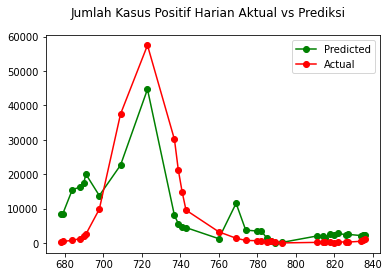

In [ ]:
#Membuat plot data prediksi vs data aktual
predicted_counts = predictions_summary_frame['mean']
actual_counts = y_test['positif_harian']
fig = plt.figure()
fig.suptitle('Jumlah Kasus Positif Harian Aktual vs Prediksi')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual')
plt.legend(handles=[predicted, actual])
plt.show()

Dari plot jumlah kasus positif harian aktual vs jumlah prediksi, terlihat bahwa jumlah prediksi memiliki pendekatan yang cukup bagus ke jumlah aktualnya, walaupun di beberapa titik terdapat perbedaan yang tidak kecil.

# **e) Conclusion**

1. Variabel mobilitas yang signifikan dalam mempengaruhi peningkatan jumlah kasus positif harian Covid-19 adalah adalah taman (parks), pusat transit (transit stations), dan tempat kerja (workplaces). 
2. Hasil pemodelan dari kegiatan mobilitas yang mempengaruhi
jumlah kasus positif harian Covid-19 pada tahun 2022
dengan menggunakan regresi Binomial
Negatif adalah 
$\mu = exp (9.6145 - 0.0149 parks - 0.0740 transitstations - 0.0140 workplaces)$ \\
Model dari regresi Binomial Negatif dapat diitepretasikan untuk setiap kenaikkan tingkat mobilitas pada area pusat transit *(transit_stations)*
sejumlah 1, dengan asumsi nilai variabel lain tetap,
maka jumlah kasus positif harian Covid-19 cenderung berkurang sebanyak $exp(0.0740) \approx 1$ jiwa, sama halnya dengan variabel lain seperti *parks*, dan *work places*
3. Berdasarkan hasil analisis data jumlah kasus positif harian Covid-19 tahun 2022, dapat dilihat bahwa variabel independen (variabel rata-rata mobilitas masyarakat) berhubungan negatif dengan variabel dependen (positif harian Covid-19) sehingga, untuk tahun 2022 variabel mobilitas berkorelasi negatif terhadap peningkatan jumlah kasus Covid-19.
4. Karena mobilitas di area pusat transit, tempat kerja, dan taman memiliki pengaruh yang signifikan terhadap peningkatan jumlah kasus Covid-19, salah satu solusi kebijakan yang dapat kami sarankan kepada pemerintah yaitu mengontrol mobilitas masyarakat terutama di area pusat transit, tempat kerja, serta taman dalam rangka menekan jumlah kasus postif Covid-19 dan meningkatkan laju pemulihan pandemi Covid-19. Pengurangan hingga pemberhentian pembatasan mobilitas masyarakat merupakan upaya yang tepat untuk pemulihan Covid-19, terutama pada sektor ekonomi. 



# **f) Daftar Pustaka**

*Datasets*:
- https://tiny.cc/Datacovidjakarta
- https://www.google.com/covid19/mobility \\


Edi Nugroho, L., &amp; Arkham Zahri Rakhman. (2021). Mobilitas Manusia Dan Tingkat penyebaran covid-19: Sebuah Analisis Kuantitatif. Jurnal Nasional Teknik Elektro Dan Teknologi Informasi, 10(2), 124–130. https://doi.org/10.22146/jnteti.v10i2.1519 \\

Keswari, N. M. R., Sumarjaya, I. W., & Suciptawati, N. L. P. (2014). Perbandingan Regresi Binomial Negatif dan Regresi Generalisasi Poisson dalam Mengatasi Overdispersi. E-Jurnal Matematika, 3(3), 107-115. \\

L.I. Oztig, O.E. Askin. (2020). Human Mobility and Coronavirus Disease 2019 (COVID-19):a Negative Binomial Regression Analysis. Retrieved July 3, 2022, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7351378/#sec2title \\

Rastika, I. (2022, June 25). Update 25 Juni 2022: Bertambah 1.831, Kasus Covid-19 di Indonesia capai 6.078.725. KOMPAS.com. Retrieved July 4, 2022, from https://nasional.kompas.com/read/2022/06/25/18190471/update-25-juni-2022-bertambah-1831-kasus-covid-19-di-indonesia-capai-6078725 \\

The negative binomial regression model. Time Series Analysis, Regression and Forecasting. (2022, May 20). Retrieved July 4, 2022, from https://timeseriesreasoning.com/contents/negative-binomial-regression-model/ \\